In [ ]:
# pip install factor_analyzer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda install -c conda-forge scikit-learn-extra

In [69]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [70]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Create dataframe of factors only
df_fct =  df.drop(['UID','Const'], axis=1)

## Exploratory Data Analysis
**Pandas-Profiling:** Used to create a full report of distributions for each variable as well as correlations.

Note: The HTML report file should be opened in your browser (not JupyterLab), and it takes a couple of minutes to load all of the correlation information.

**Correlation Plot:** Seaborn plot of Pearson correlations between factor variables.

There is clearly an increased correlation between variables in groups of 6.

In [ ]:
# Create pandas-profiling report
profile = ProfileReport(df_fct, title="Pandas Profiling Report", minimal=True)
profile.to_file("profiling_report.html")

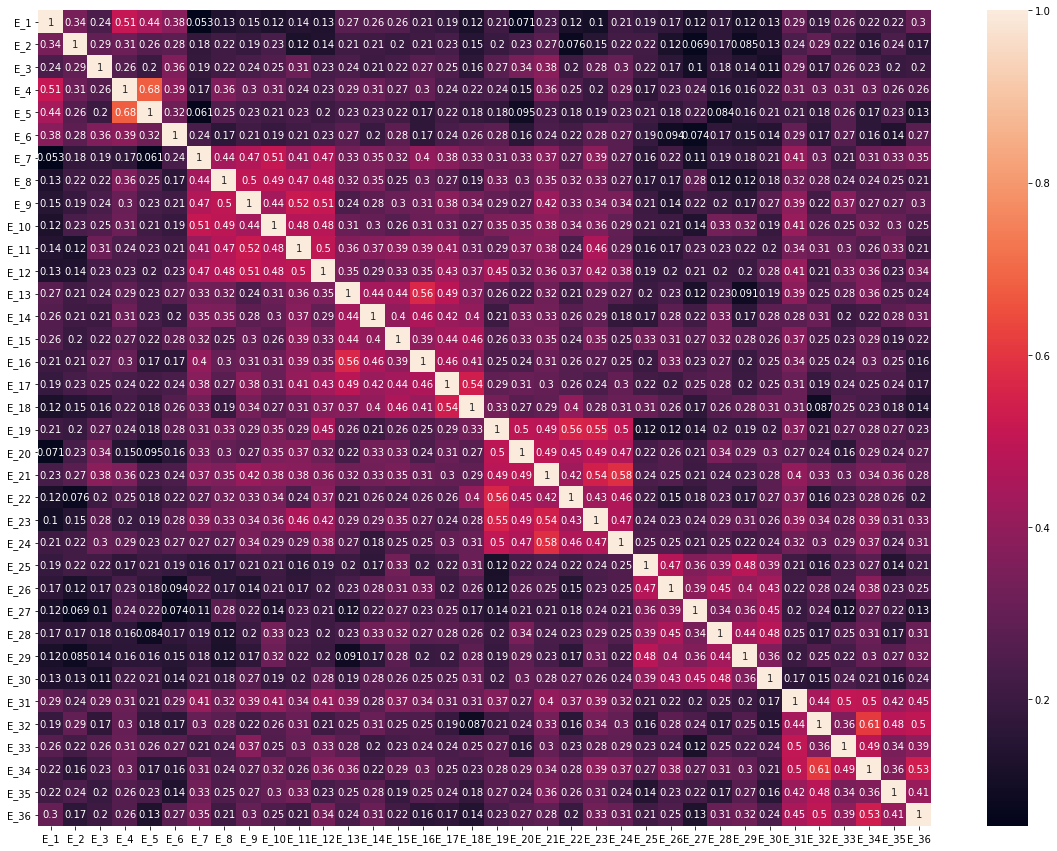

In [5]:
# Visually inspect for any strong correlations between variables
corrMatrix = df_fct.corr()

fig, ax = plt.subplots(figsize=(20,15))  # There are a lot of factors, so I made the figure large enough to see each of them

sn.heatmap(corrMatrix, annot=True)
plt.show()

## Factor Analysis

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

Note: I think a varimax rotation might be good here because it will create more sparsity in the columns and help identify latent factors.  We can see in the correlation plot above that some variables are more similar than others, and a varimax rotation will help tease that out.

In [71]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=len(df_fct.columns), rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
rotation = 'varimax'
n_factors = sum(i >= 1 for i in ev)
fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,n_factors+1),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:n_factors],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:n_factors],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))
scores

,0,1,2,3,4,5,6,7
0,-0.334964,-0.578483,0.375932,-0.178896,-0.232741,0.051477,0.253261,0.261287
1,-0.203407,1.234689,-0.657947,0.663021,-0.781508,-0.406496,0.199490,0.038285
2,0.050422,1.084946,0.416432,0.449895,0.119567,0.345467,0.162377,-0.552346
3,-0.574717,-0.387999,-0.449162,0.249278,0.240755,-0.454138,0.489530,0.560242
4,0.216304,-0.953627,-0.062940,1.005123,-0.455745,0.214732,0.286778,0.119431
...,...,...,...,...,...,...,...,...
419,-1.047173,0.296518,-0.966288,0.041474,-1.869971,-0.517969,0.769399,0.525922
420,0.488634,-0.121466,-0.392372,0.818895,0.876936,2.310135,1.190467,-1.375181
421,0.365723,0.326988,0.810250,-0.134353,0.433100,-1.782451,-0.709297,0.515692
422,-0.076151,1.120773,1.415818,-0.381365,0.129095,-0.672036,0.529317,0.832299


### Clustering

In [41]:
sw=[]

for i in range (2,7):
    i_stats = []
    algorithm = "kMedoids"
    kMedoids = KMedoids(n_clusters=i, random_state=0)
    kMedoids.fit(scores)
    clusters=kMedoids.fit_predict(scores)
    silhouette_avg = silhouette_score(scores,clusters)  # 1 is a perfect score, -1 is worst score
    i_stats.append(algorithm)
    i_stats.append(i)
    i_stats.append(silhouette_avg)
    i_stats.append(clusters)
    sw.append(i_stats)
    print(f"{i} k-medoid clusters: {round(silhouette_avg,3)}")

for i in range (2,7):
    i_stats = []
    algorithm = "kMeans"
    kMeans = KMeans(n_clusters=i, random_state=0)
    kMeans.fit(scores)
    clusters=kMeans.labels_
    silhouette_avg = silhouette_score(scores,clusters)  # 1 is a perfect score, -1 is worst score
    i_stats.append(algorithm)
    i_stats.append(i)
    i_stats.append(silhouette_avg)
    i_stats.append(clusters)
    sw.append(i_stats)
    print(f"{i} k-means clusters: {round(silhouette_avg,3)}")

# Reorder cluster lists by descending silhouette scores.  Clusters in first element should be assigned to training data.
sw = sorted(sw, key=itemgetter(2), reverse=True)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
df_fct['cluster'] = sw[0][3]

2 k-medoid clusters: 0.079
3 k-medoid clusters: 0.05
4 k-medoid clusters: 0.015
5 k-medoid clusters: -0.009
6 k-medoid clusters: -0.003
2 k-means clusters: 0.141
3 k-means clusters: 0.105
4 k-means clusters: 0.133
5 k-means clusters: 0.125
6 k-means clusters: 0.083


### Classification

In [72]:
clf_scores = []

# Split data into 80% training, 20% test
train, test = train_test_split(df_fct, test_size=0.2, random_state=123)

# X is unlabeled training data, y is true training labels 
X, y = train.loc[:, train.columns != 'cluster'], train['cluster']

X_test, y_test = test.loc[:, test.columns != 'cluster'], test['cluster']

KeyError: 'cluster'

#### Random Forest

In [75]:
alg = 'random_forest'

# Create the Random Forest object
clf = RandomForestClassifier(random_state=0)

# Fit the model to the training data
clf.fit(X,y)

# Score model
print(clf.score(X_test,y_test))

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

clf_scores.append(results)

0.9647058823529412


#### Gradient Boosting

In [76]:
alg = 'gradient_boosting'

# Create the Random Forest object
clf = GradientBoostingClassifier(random_state=0)

# Fit the model to the training data
clf.fit(X,y)

# Score model
print(clf.score(X_test,y_test))

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

clf_scores.append(results)

0.9176470588235294


In [82]:
clf_scores = sorted(clf_scores, key=itemgetter(1), reverse=True)

In [83]:
clf_scores

[['random_forest', 0.9647058823529412],
 ['gradient_boosting', 0.9176470588235294]]

# Support Vector Machine

In [74]:
from sklearn.svm import SVC

alg = 'support_vector_machine'

clf = SVC()
clf.fit(X, y)
clf.score(X_test,y_test)

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

'''Note, you can update the paramters like 
model = SVC(C=10)
model = SVC(gamma=100)
from sklearn.svm import SVC
model = SVC()

model.fit(X_train, y_train)

model.score(X_test,y_test)

Note, you can update the paramters like 
model = SVC(C=10)
model = SVC(kernel='linear')

Note: use Shift + Tab for the different options to pop up.
'''

NameError: name 'X' is not defined

**Next Steps**
* Is there an AutoML library for clustering/classification that we can use to autocluster and autoclassify
* Can we convert/bin all variable values to 1, 2, or 3 and then run the classification on that?
* If we look across rows, that will show an individual's preferences.  If we look down columns, that will show population preferences.
* Ensembling classifiers
* Adding and ensembling cluster algorithms
* Hyperparameter tuning on classifiers
* Meet with someone from NC State who can give some input

In [57]:
importance = pd.DataFrame(clf.feature_importances_)

<AxesSubplot:>

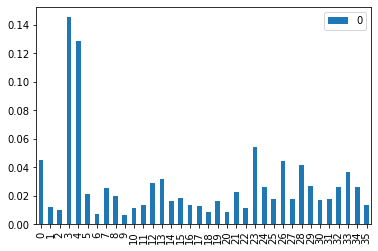

In [60]:
importance.plot(kind='bar')

## The Big Picture

Start with raw, unlabeled data - 400 data points in the population

Cluster and label all 400 data points

--- Some time passes, the clusters are evaluated.  Turns out, they are excellent!

--- New project comes along to assign clusters/personas to new customers

Split the original 400 classified data points and hold out 20% for evaluation

Create and evaluate classifiers (RF, Boost) based on the original 400 folks

### 5 Factors, Quartimax Rotation
In the heatmap below, Factor 1 clearly explains the most variance.  The other four factors have clearly defined areas of explained variance.

**Want to add a rotation variable, we will start with varimax and have both varimax and quartimax as options**

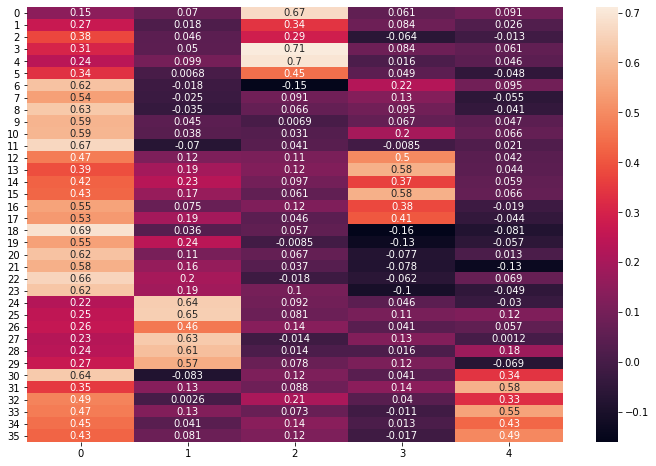

In [70]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=5, rotation='quartimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

### 5 Factors, Varimax Rotation
I decided to try a varimax rotation to create sparsity in the loadings and amplify those clearly defined areas of variance explanation.  The increase in loading values is not profound, but you can see that the clearly defined areas of Factors 2-5 have fewer dark orange/red cells, meaning the rotation increased the amount of variance explained by that particular factor.

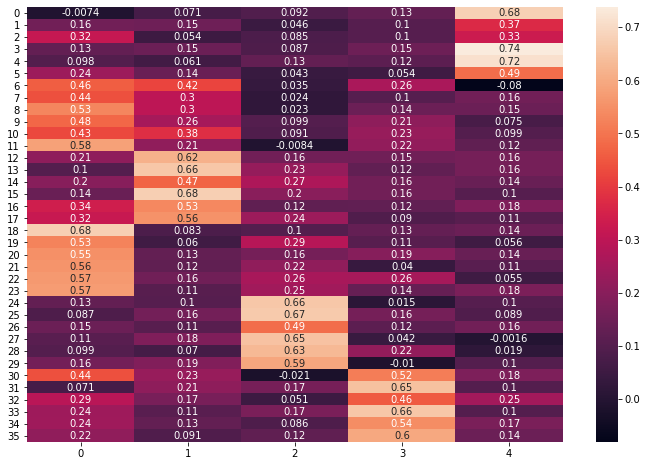

In [74]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=5, rotation='varimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

### 6 Factors, Varimax Rotation
Because the correlation matrix of the original data suggested that there are 6 major areas of correlation within the original dataset, I tried 6 factors and a varimax rotation.  As expected, 6 distinct areas of variance explanation emerged across the factors.  

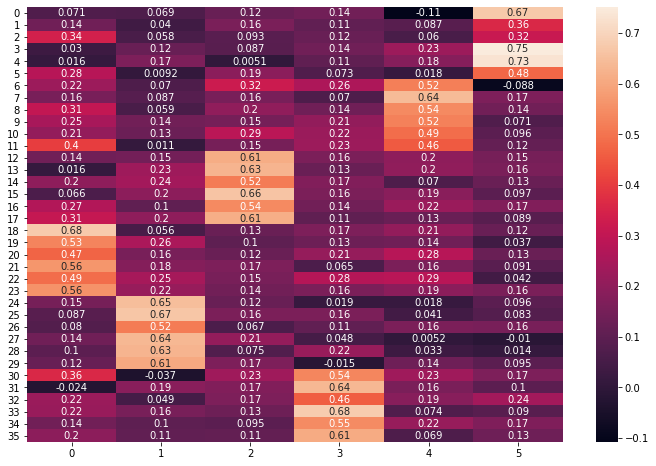

In [114]:
# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=6, rotation='varimax')

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Plot heatmap of loadings matrix
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(loadings, annot=True)
plt.show()

In [84]:
# ev, v = fa.get_eigenvalues()

array([10.39884088,  2.50580935,  2.16116051,  1.75353888,  1.68636087,
        1.30945212])

In [8]:
# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,6),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:5],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:5],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

cov_matrix_eigenvals

,eigenvalues,common_factor_eigenvalues,variance,proportional_variance,cumulative_variance
factor,,,,,
1,9.903904,9.338739,3.837985,0.106611,0.106611
2,2.534419,1.948795,3.519316,0.097759,0.204369
3,2.090248,1.536404,2.755369,0.076538,0.280907
4,1.780928,1.225674,2.711779,0.075327,0.356235
5,1.673402,1.141004,2.366169,0.065727,0.421962


The 6 factors identified here account for 46.4% of variance in the original dataset.

In [160]:
# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))
scores

,0,1,2,3,4,5
0,-0.188004,-0.497844,0.555861,0.832474,-1.153578,0.093972
1,0.205463,1.149237,0.061470,-0.117163,-0.730490,0.340247
2,-0.688069,-0.209683,1.796512,1.027487,0.539417,0.059302
3,0.857078,0.279668,0.107772,0.645241,1.832044,0.393290
4,0.995301,-0.048309,0.238854,1.247254,0.339786,0.103404
...,...,...,...,...,...,...
334,-0.014141,0.011961,0.094100,-0.021071,-0.101294,0.009588
335,1.028733,-0.970974,0.434159,-3.789930,-0.246281,-0.981048
336,0.058987,-0.647055,0.346634,0.786542,-1.261906,0.776749
337,-2.036361,1.878056,1.177578,-3.153955,-0.336626,-1.328714


## k-Means Clustering
The original variables separated into 6 factors very nicely, so I used 6 clusters.  I'm not totally confident in this.  I feel like the loadings and scores might give us the info we need to label or create some sort of model to score test data/new data.

In [157]:
# Create the KMeans object and group the scores into 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(scores)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
train['cluster'] = kmeans.labels_

# Number of customers in each cluster
train['cluster'].value_counts()

C:\Users\ericd\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    134
4     73
2     50
0     33
3     28
5     21
Name: cluster, dtype: int64

<div class="alert alert-block alert-info">
  

## **Still To Do:**
* More research to figure out the best way to connect the loadings to test data to cluster correctly
* Research k-Medoids and how it might work with a Pearson distance metric

<br>    

</div>

<hr style="border-top: 5px solid gray; margin-top: 10px; margin-bottom: 10px"></hr>

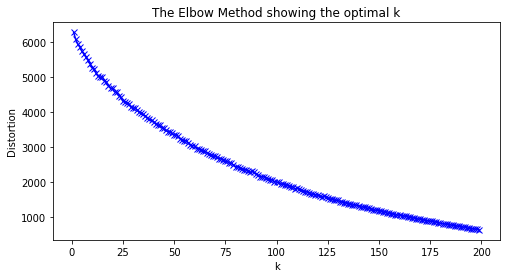

In [30]:
# Create elbow plot for k-means clustering
# This plot doesn't show much of an elbow, just a gentle curve.
distortions = []
K = range(1,200)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scores)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:


# Clustering chunk
for clustering_algorithm in list of algorithms:
    for clusters in algorithm:
        do the clusters
        score with sillhouette or something else  (for later: ensemble clusters with Cluster_Ensembles package or something)
        save to score array/dataframe (algirthm, cluster number, score)
    choose best score
    append clusters to raw data for use in classification
    
# Classification chunk
# list of algorithms: Random Forest, boosted trees (XG, LiteGBM), KNN, Fisher's linear discriminant analysis, LASSO
# Options: cross-validation, ensemble of predicted probabilities(?)
# Consideration: If only two clusters, then could also use binary classification, like binary logistic regression
# Consideration: If extra variables are added for classification, then would need to encode categorical values
# Final result: Classified
    


    
First iteration:
    Only continuous variables
    silhouette scoring or something very similar with existing packages
    Choosing best score to select the "winning" clustering solution
    Classification without any consideration of two clusters only or categorical input variables
    Start with k-means and k-medoids for Clustering
    Start with RF and Boosted Trees for Classification




## David's Original Work

In [19]:
xvals = range(1, df_fct.shape[1]+1)

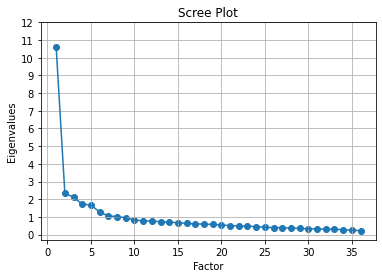

In [20]:
# Create scree plot
plt.scatter(xvals,ev)
plt.plot(xvals, ev)
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalues')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.show()

In [16]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [17]:
v

array([ 1.00384127e+01,  1.76655893e+00,  1.57385891e+00,  1.18512982e+00,
        1.13391096e+00,  6.96962949e-01,  4.64937967e-01,  4.23663399e-01,
        3.47115063e-01,  2.29655462e-01,  2.05732370e-01,  2.01155005e-01,
        1.37720907e-01,  1.27301511e-01,  9.46998026e-02,  8.27808421e-02,
        6.90442002e-02,  1.09338178e-02,  4.89412079e-03, -1.63612698e-02,
       -4.27394901e-02, -8.11548252e-02, -8.92359590e-02, -1.13228783e-01,
       -1.34440020e-01, -1.47318115e-01, -1.74436124e-01, -1.84286635e-01,
       -2.04186908e-01, -2.15724482e-01, -2.39301301e-01, -2.59729230e-01,
       -2.80931631e-01, -2.82997622e-01, -3.07658120e-01, -3.22865387e-01])

In [12]:
eigen=pd.DataFrame(v,columns=['eigenvalues']) 


In [13]:
ev

array([10.59267071,  2.33116666,  2.11377727,  1.71775964,  1.67322846,
        1.27020224,  1.06415029,  1.01468701,  0.95459751,  0.8236991 ,
        0.77574707,  0.76307285,  0.72927801,  0.70705429,  0.6709557 ,
        0.63189162,  0.60224659,  0.59349459,  0.57697191,  0.53641124,
        0.51445916,  0.48302656,  0.47663102,  0.45151838,  0.41396747,
        0.39596126,  0.39279193,  0.37517128,  0.34890969,  0.33141645,
        0.31924346,  0.30453058,  0.30095566,  0.27860251,  0.24513374,
        0.22461809])

In [14]:
num_of_facts=sum(i >= 1 for i in ev)

In [15]:
fa = FactorAnalyzer(n_factors=num_of_facts,rotation='quartimax')

In [16]:
fa.fit(df_fct)

FactorAnalyzer(n_factors=8, rotation='quartimax', rotation_kwargs={})

In [17]:
loadings = fa.loadings_

In [18]:
len(loadings)

36

In [26]:
import pandas as pd 
factor_scores = fa.transform(df_fct)
factor_scores = pd.DataFrame(factor_scores)
loadings = pd.DataFrame(loadings)
factor_scores.to_excel('C:/kmeans/factor_scores.xlsx')
loadings.to_excel('C:/kmeans/loadings.xlsx')


In [49]:
loadings_abs=loadings.abs()
loadings[loadings.abs() >= .4].count()



0    16
1     6
2     3
3     6
4     6
5     1
6     1
7     0
dtype: int64

Below is for KMEANS Clustering

In [38]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import numpy as np

In [55]:
X=df_fct
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)

In [57]:
plt.scatter(X[:,0],X[:,36], c=kmeans.labels_, cmap='rainbow')

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [56]:
clusters

array([0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0,
       1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2,
       0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0,

In [59]:
mglearn.plots.plot_dbscan()

NameError: name 'mglearn' is not defined

In [61]:
from sklearn.cluster import DBSCAN

In [1]:
from scipy.stats import pearsonr
import numpy as np


In [2]:
def pearson_affinity(M):
   return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])